# DEEP LEARNING FOR COMPUTER VISION: <br> A PRACTITIONER's VIEWPOINT

### André Panisson <br> Alan Perotti 
#### ISI Foundation
---

## Learning Theory in a Nutshell

### A few things that even a practitioner should know.

In this notebook, we will see how the theory of approximation-generalization works in practice, by producing and interpreting the learning curves for different models.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Let's consider a simple 1D regression problem.  This will help us to
easily visualize the data and the model, and the results generalize easily to  higher-dimensional
datasets.  We'll explore a simple **linear regression** problem.
This can be accomplished within scikit-learn with the `sklearn.linear_model` module.

We'll create a simple nonlinear function that we'd like to fit.

In [2]:
def make_data(N=30, err=0.8, seed=1):
    # randomly sample the data
    rng = np.random.RandomState(seed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(1000, seed=1)

In [3]:
X_train = X[:30]
y_train = y[:30]

X_fit = np.linspace(-0.1, 1.1, 500)[:, np.newaxis]

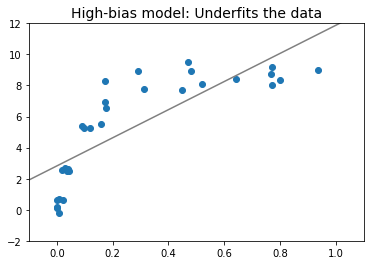

In [4]:
from sklearn.linear_model import LinearRegression

model1 = LinearRegression().fit(X_train, y_train)

plt.scatter(X_train.ravel(), y_train)
plt.plot(X_fit.ravel(), model1.predict(X_fit), color='gray')
plt.axis([-0.1, 1.1, -2, 12])
plt.title('High-bias model: Underfits the data', size=14);

We have fit a straight line to the data, but clearly this model is not a good choice.  We say that this model has a high **bias**, or that it **under-fits** the data.

Let's try to improve this by creating a more complicated model. We can do this by adding degrees of freedom, using a **polynomial regression** model: this is a generalized linear model in which the degree of the polynomial is a tunable parameter.
For example, a degree-1 polynomial fits a straight line to the data; for model parameters $a$ and $b$:

$$
y = ax + b
$$

A degree-3 polynomial fits a cubic curve to the data; for model parameters $a, b, c, d$:

$$
y = ax^3 + bx^2 + cx + d
$$

We can generalize this to any number of polynomial features.
In Scikit-Learn, we can implement this with a simple linear regression combined with a polynomial transformation of the input.

In [5]:
class PolynomialRegression(LinearRegression):
    """Simple Polynomial Regression to 1D data"""
    def __init__(self, degree=1, **kwargs):
        self.degree = degree
        LinearRegression.__init__(self, **kwargs)
        
    def fit(self, X, y):
        if X.shape[1] != 1:
            raise ValueError("Only 1D data valid here")
        Xp = X ** (1 + np.arange(self.degree))
        return LinearRegression.fit(self, Xp, y)
        
    def predict(self, X):
        Xp = X ** (1 + np.arange(self.degree))
        return LinearRegression.predict(self, Xp)

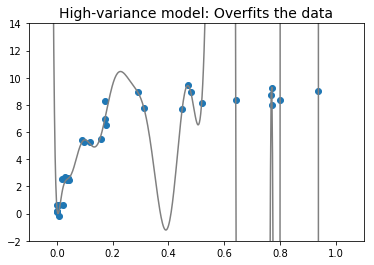

In [6]:
model20 = PolynomialRegression(20).fit(X_train, y_train)

plt.scatter(X_train.ravel(), y_train)
plt.plot(X_fit.ravel(), model20.predict(X_fit), color='gray')
plt.axis([-0.1, 1.1, -2, 14])
plt.title('High-variance model: Overfits the data', size=14);

This last model attempts to fit a high-order polynomial through the data. Here the model has enough flexibility to nearly perfectly account for the fine features in the data, but even though it very accurately describes the training data, its precise form seems to be more reflective of the particular noise properties of the data rather than the intrinsic properties of whatever process generated that data. Such a model is said to **overfit** the data: that is, it has so much model flexibility that the model ends up accounting for random errors as well as the underlying data distribution; another way of saying this is that the model has **high variance**.

To look at this in another light, consider what happens if we use these two models to predict the y-value for some new data. In the following diagrams, the red/lighter points indicate data that is omitted from the training set:

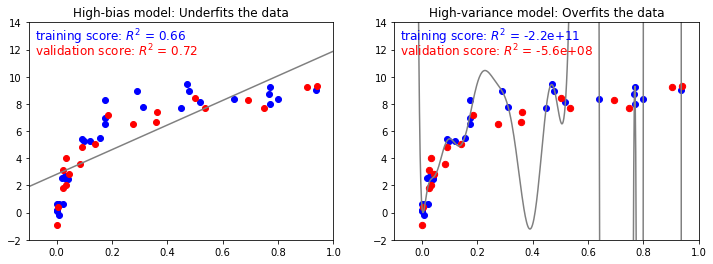

In [7]:
X_test, y_test = make_data(20, seed=42)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

ax[0].scatter(X_train.ravel(), y_train, c='blue')
ax[0].plot(X_fit.ravel(), model1.predict(X_fit), color='gray')
ax[0].axis([-0.1, 1.0, -2, 14])
ax[0].set_title('High-bias model: Underfits the data', size=12)
ax[0].scatter(X_test.ravel(), y_test, c='red')

ax[0].text(0.02, 0.98, "training score: $R^2$ = {0:.2f}".format(model1.score(X, y)),
           ha='left', va='top', transform=ax[0].transAxes, size=12, color='blue')
ax[0].text(0.02, 0.91, "validation score: $R^2$ = {0:.2f}".format(model1.score(X_test, y_test)),
           ha='left', va='top', transform=ax[0].transAxes, size=12, color='red')

ax[1].scatter(X_train.ravel(), y_train, c='blue')
ax[1].plot(X_fit.ravel(), model20.predict(X_fit), color='gray')
ax[1].axis([-0.1, 1.0, -2, 14])
ax[1].set_title('High-variance model: Overfits the data', size=12)
ax[1].scatter(X_test.ravel(), y_test, s=40, c='red')
ax[1].text(0.02, 0.98, "training score: $R^2$ = {0:.2g}".format(model20.score(X, y)),
           ha='left', va='top', transform=ax[1].transAxes, size=12, color='blue')
ax[1].text(0.02, 0.91, "validation score: $R^2$ = {0:.2g}".format(model20.score(X_test, y_test)),
           ha='left', va='top', transform=ax[1].transAxes, size=12, color='red');

The score here is the $R^2$ score, or [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination), which measures how well a model performs relative to a simple mean of the target values:

$$R^2(y, \hat{y}) = 1 - \frac{\sum_{i=0}^{n_{\text{samples}} - 1} (y_i - \hat{y}_i)^2}{\sum_{i=0}^{n_\text{samples} - 1} (y_i - \bar{y})^2}$$

where $\bar{y} =  \frac{1}{n_{\text{samples}}} \sum_{i=0}^{n_{\text{samples}} - 1} y_i$.

$R^2=1$ indicates a perfect match, $R^2=0$ indicates the model does no better than simply taking the mean of the data, and negative values mean even worse models.
From the scores associated with these two models, we can make an observation that holds more generally:

- For high-bias models, the performance of the model on the validation set is similar to the performance on the training set.
- For high-variance models, the performance of the model on the validation set is far worse than the performance on the training set.

## Model Selection: Tuning Model Complexity

The number of effective parameters that we can adjust in our model represents the model complexity. More parameters we can adjust (higher polynomial order in this example) means that the model is more complex.

If we have a **fixed training set**, we can only choose how much the model is complex. A model that is too simple will underfit the data, and a model that is too complex will overfit the data. 

If we check both the training scores and the validation scores for this example, we have the following curve:

Best choice for polynomial degree: 6


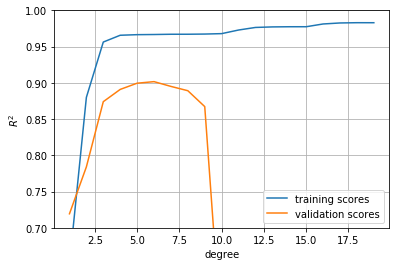

In [8]:
degrees = np.arange(1, 20)

training_scores = []
test_scores = []

for d in degrees:
    model = PolynomialRegression(d).fit(X_train, y_train)
    training_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))
    
plt.plot(degrees, training_scores, label='training scores')
plt.plot(degrees, test_scores, label='validation scores')
plt.legend()
plt.xlabel('degree')
plt.ylabel('$R^2$')
plt.ylim(0.7, 1);
plt.grid()

print("Best choice for polynomial degree: {}".format(degrees[np.argmax(test_scores)]))

This is an example of a **validation curve**, and we see the following essential features:

- The **training score is higher than the validation score** (except for some statistical fluctuations). This is generally the case: the model will be a better fit to data it has seen than to data it has not seen.
- A model with **low complexity** (a high-bias model) **underfits the data**, which means that the model is a poor predictor both for the training data and for any previously unseen data. In this case we observe low approximation and high generalization.
- A model with **high complexity** (a high-variance model) **overfits the data**, which means that the model predicts the training data very well, but fails for any previously unseen data. In this case, we observe high approximation but low generalization.
- For some intermediate value, the validation curve has a maximum. This level of complexity indicates a **suitable trade-off between bias and variance**, and the right complexity where we can observe both high approximation and high generalization.

<img src="./figures/validation-curve.png"/>

If we change the training set by increasing the number of training points, we will observe a different validation curve:

Best choice for polynomial degree: 18


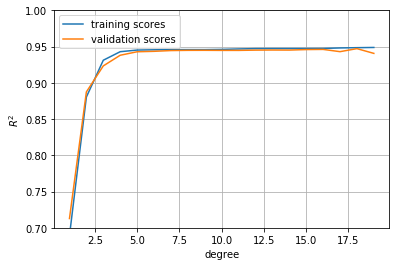

In [9]:
degrees = np.arange(1, 20)

N = 100
X2, y2 = make_data(N)
X2_test, y2_test = make_data(N, seed=42)

training_scores = []
test_scores = []

for d in degrees:
    model = PolynomialRegression(d).fit(X2, y2)
    training_scores.append(model.score(X2, y2))
    test_scores.append(model.score(X2_test, y2_test))
    
plt.plot(degrees, training_scores, label='training scores')
plt.plot(degrees, test_scores, label='validation scores')
plt.legend()
plt.xlabel('degree')
plt.ylabel('$R^2$')
plt.ylim(0.7, 1)
plt.grid()

print("Best choice for polynomial degree: {}".format(degrees[np.argmax(test_scores)]))

This means that the number of training examples plays also an important role in the behaviour of the validation curves.

Now let's look at what happens to the $R^2$ for different values of $N$:

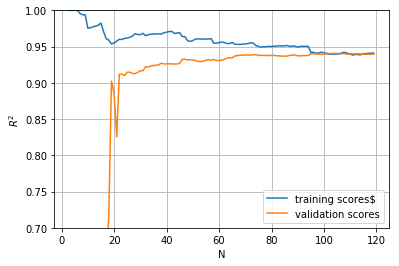

In [15]:
model = PolynomialRegression(degree=5)

training_scores = []
test_scores = []

N_list = range(3, 120)
X_test, y_test = make_data(100, seed=42)

for N in N_list:
    X_train = X[:N]
    y_train = y[:N]
    
    model.fit(X_train, y_train)
    training_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))
    
plt.plot(N_list, training_scores, label='training scores$')
plt.plot(N_list, test_scores, label='validation scores')
plt.legend()
plt.xlabel('N')
plt.ylabel('$R^2$')
plt.grid()
plt.ylim(0.7, 1);

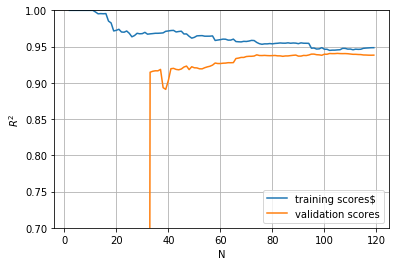

In [16]:
model = PolynomialRegression(degree=10)

training_scores = []
test_scores = []

N_list = range(2, 120)

for N in N_list:
    X_train = X[:N]
    y_train = y[:N]
    
    model.fit(X_train, y_train)
    training_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))
    
plt.plot(N_list, training_scores, label='training scores$')
plt.plot(N_list, test_scores, label='validation scores')
plt.legend()
plt.xlabel('N')
plt.ylabel('$R^2$')
plt.grid()
plt.ylim(0.7, 1);

<img src="figures/learning-curve.png"/>

In general, the **validation score** will always be the **training score** minus a **penalty**, and this penalty depends on **N** (the number of samples in the training set) and on the **model complexity**. The higher is N, the lower is the penalty. The higher is the model complexity, the higher is the penalty. The more complex is the model, the more samples you need to generalize better.

You can think about this as if you are building a **rocket**, and you need **fuel** to make it fly. The bigger is the rocket, the more fuel you need to make it fly!

<img src="figures/rocket.png"/>

### If you want to learn more:

- [Learning From Data](http://amlbook.com/), a book from Yaser S. Abu-Mostafa, Malik Magdon-Ismail, and Hsuan-Tien Lin with many concepts about learning theory (with video lessons!).
- [Statistical Learning Theory](https://www.wiley.com/en-us/Statistical+Learning+Theory-p-9780471030034), from Vladimir N. Vapnik.
- [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/), an interactive book (written using Jupyter Notebooks) form Jake VanderPlas.


---
# Extended Lesson

### The tutorial stops here, but below you'll find material about some other concepts that might be useful for a Machine Learning practitioner's everyday life.

### Cross validation

Cross-validation (CV) is a model validation technique for assessing how the results of a model will generalize to an independent data set using all points in the dataset for validation.

In the basic CV approach, called *k*-fold CV,
the training set is split into *k* smaller sets.
The following procedure is followed for each of the *k* "folds":

 * A model is trained using $k-1$ of the folds as training data;
 * the resulting model is validated on the remaining part of the data
   (i.e., it is used as a test set to compute a performance measure
   such as accuracy).

The performance measure reported by *k*-fold cross-validation
is then the average of the values computed in the loop.
This approach can be computationally expensive,
but does not waste too much data
(as it is the case when fixing an arbitrary test set)

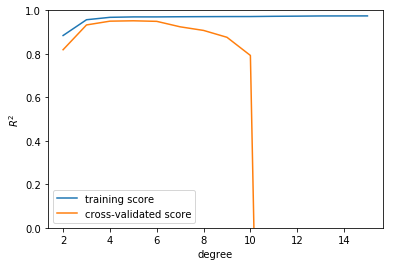

In [12]:
from sklearn import model_selection
N = 40
X_train = X[:N]
y_train = y[:N]

degrees = np.arange(2, 16)

training_scores = []
test_scores = []

for d in degrees:
    model = PolynomialRegression(d).fit(X_train, y_train)
    training_scores.append(model.score(X_train, y_train))
    
    scores = model_selection.cross_val_score(model, X_train, y_train, cv=5)
    test_scores.append(np.mean(scores))

# note that the test error can also be computed via cross-validation
plt.plot(degrees, training_scores, label='training score')
plt.plot(degrees, test_scores, label='cross-validated score')
plt.legend()
plt.xlabel('degree')
plt.ylabel('$R^2$')
plt.ylim(0.0, 1.0);

### Regularization

With regularization, we add constraints to the model, by limiting the space of the parameter values.

For example, with L1 regularization, we add a term to the error function:
$$\alpha \sum_{d=0}^D {|w_d|}$$
With L2 regularization, we add this term:
$$\alpha \sum_{d=0}^D {w_d^2} $$
For example, the error function of Linear Regression with L1 regularization becomes
$$ \frac{1}{N} \sum_{i=1}^N {\left( \mathbf{w}x_i - y_i \right)^2} + \alpha \sum_{d=0}^D |{w_d}| $$
With regularization, we are not free to change all parameters independently: If we set one parameter to a high value, we implicitly force other parameters to be smaller. The degrees of freedom thus are smaller than without the restriction. As result, we are reducing the effective parameters (or VC dimension).

In [13]:
from sklearn.linear_model import Lasso

class RegularizedPolynomialRegression(Lasso):
    """Simple Polynomial Regression to 1D data"""
    def __init__(self, degree=1, alpha=1.0, **kwargs):
        self.degree = degree
        self.alpha = alpha
        Lasso.__init__(self, alpha=alpha, max_iter=100000, tol=0.01, **kwargs)
        
    def fit(self, X, y):
        if X.shape[1] != 1:
            raise ValueError("Only 1D data valid here")
        Xp = X ** (1 + np.arange(self.degree))
        return Lasso.fit(self, Xp, y)
        
    def predict(self, X):
        Xp = X ** (1 + np.arange(self.degree))
        return Lasso.predict(self, Xp)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


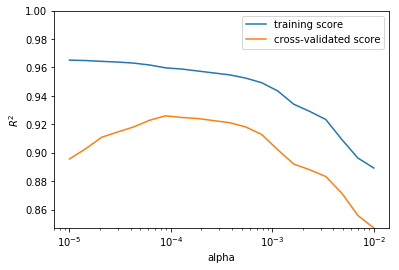

In [14]:
from sklearn import model_selection

X_train, y_train = make_data(40)

degree = 100
alphas = np.logspace(-5, -2, 20)

training_scores = []
test_scores = []

for alpha in alphas:
    model = RegularizedPolynomialRegression(degree, alpha=alpha).fit(X_train, y_train)
    training_scores.append(model.score(X_train, y_train))
    
    scores = model_selection.cross_val_score(model, X_train, y_train, cv=5)
    test_scores.append(np.mean(scores))

# note that the test error can also be computed via cross-validation
plt.plot(alphas, training_scores, label='training score')
plt.plot(alphas, test_scores, label='cross-validated score')
plt.legend()
plt.xlabel('alpha')
plt.ylabel('$R^2$')
plt.xscale('log')
plt.ylim(np.min(test_scores), 1.);